Realizamos la Importacion las librerias necesarias

In [1]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml import automl

Instanciar un cliente de ML con Azure

In [2]:
credential = DefaultAzureCredential()
ml_client = MLClient.from_config(credential)

Found the config file in: /config.json


Descargamos el dataset en la Instance que ejecuta este notebook

Creamos el directorio y definimos el nombre del dataset.
Dataset utilizado: Fire dataset
Kaggle link: https://www.kaggle.com/datasets/phylake1337/fire-dataset/
Nota: El dataset fue cargado a dropbox para tener un link de descarga, ya que kaggle solicita logearse para poder hacer la descarga.
El dataset fue creado para desarrollar un modelo que pueda reconocer imagenes con fuego.
La data esta dividido en 2 folders: el primero (fire_images) cuenta con 755 imagenes de exterior con fuego algunas con humo en cantidad, el 2do folder (non-fire_images) contiene 244 imagenes de la naturaleza(bosque, arboles, rios, personas, animales etc.)

In [3]:
import os
import urllib
from zipfile import ZipFile

# Definimos el directorio en el que se encontrará el dataset
dataset_parent_dir = "./data"

# Creamos el folder si este no existe
os.makedirs(dataset_parent_dir, exist_ok=True)

# Descargamos el dataset (zip file)
# download_url = "http://dl.dropboxusercontent.com/scl/fi/vunb18zup3gbyr8y1y9pc/fire_dataset.zip?rlkey=xx02qvqkavsm1i7i9qps44ub5&dl=0" JPG
download_url = "http://dl.dropboxusercontent.com/scl/fi/vt8xqj3lt67fm2a5siil9/fire_dataset.zip?rlkey=rt5r7hcs9w6h6dr4sxocey9qb&dl=0"

# Definimos el nombre del dataset
dataset_name = "fire_dataset"

# Definimos el directorio del dataset = ./data/fire_dataset
dataset_dir = os.path.join(dataset_parent_dir, dataset_name)

print(dataset_name)
print(dataset_dir)

fire_dataset
./data/fire_dataset


Descargamos el archivo .zip
El dataset al ser computer vision, y obtener las imagenes en el .zip no necesita hacerse la limpieza de datos.

In [4]:
# Get the data zip file path ./data/fire_dataset.zip
data_file = os.path.join(dataset_parent_dir, f"{dataset_name}.zip")

# Descargamos el dataset en data_file = ./data/fire_dataset.zip
urllib.request.urlretrieve(download_url, filename=data_file)

# Extraemos la carpeta fire_dataset del zip file al directorio ./data/
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall(path=dataset_parent_dir)
    print("done")

# Eliminamos el zip file para que no ocupe inecesariamente espacio en la instancia
os.remove(data_file)

extracting files...
done


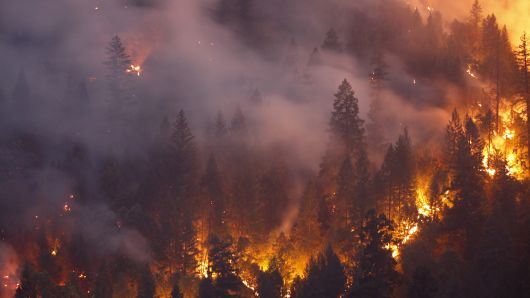

In [6]:
# Mostramos una imagen para verificar que las imagenes hayan sido extraidas apropiadamente y estamos usando la estructura de directorios correcta
from IPython.display import Image
sample_image = os.path.join(dataset_dir, "fire_images", "005.png") #./data/fire_dataset/fire_images/005.png
Image(filename=sample_image)

**Subimos el dataset al Data Blob Storage**

In [7]:
# Importamos las librerias necesarias del SDK
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

In [8]:
my_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="fire and non-fire images",
    name="fire-images-png",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy '/mnt/batch/tasks/shared/LS_root/mounts/clusters/new-notebook-instance/code/Users/velasquito.md/data/fire_dataset' 'https://project15110851388.blob.core.windows.net/azureml-blobstore-2529274f-eb40-47ee-99d6-bf10bf3c7049/LocalUpload/336a247584f8fd84dccd4763d7781e77/fire_dataset' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Uploading fire_dataset (408.78 MBs): 100%|██████████| 408783015/408783015 [00:15<00:00, 26062646.12it/s]




In [10]:
#Verificamos el uri folder donde se subió el folder de imagenes
uri_folder_data_asset.path

'azureml://subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/resourcegroups/computer-vision-project/workspaces/project-1/datastores/workspaceblobstore/paths/LocalUpload/336a247584f8fd84dccd4763d7781e77/fire_dataset/'

**Creamos el archivo JSONL**

La libería _jsonlines_ será instalada en el kernel "Python 3.8", por ello esta ultima parte será trabajada con ese kernel.  
Sin embargo este kernel no tiene instalado los paquetes del SDk de azure (azure.ai.ml), que si estan instalados en _Python 3.10 - SDK v2_

In [1]:
#Instalamos el package para trabajar con jsonlines
!pip install jsonlines

In [2]:
import os
from PIL import Image
import jsonlines

# Define the directory where your images are located
image_dir = "./data/fire_dataset/"
blob_storage_objects_path='azureml://subscriptions/a3ceb55c-eb6c-4fb9-920b-527d0ef94616/resourcegroups/computer-vision-project/workspaces/project-1/datastores/workspaceblobstore/paths/LocalUpload/336a247584f8fd84dccd4763d7781e77/fire_dataset/'

# *** Define the output JSONL file path ***
output_jsonl_file = "fire_images.jsonl"

# List of classes
classes = ["fire_images", "non_fire_images"]

# Open the JSONL file for writing
with jsonlines.open(output_jsonl_file, mode='w') as writer:
    # Loop through each class directory
    for class_name in classes:
        class_dir = os.path.join(image_dir, class_name)
        # Check if the class directory exists
        if os.path.exists(class_dir) and os.path.isdir(class_dir):
            # List all image files in the class directory
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            print(f'images found in {class_dir}: {len(image_files)}')
            # Loop through each image file
            for image_file in image_files:
                # Construct the full image path
                image_path = os.path.join(class_dir, image_file)
                
                # Open the image to get its details
                with Image.open(image_path) as img:
                    image_details = {
                        # "format": img.format,
                        "format": 'png',
                        "width": img.width,
                        "height": img.height
                    }
                img_path_names = image_path.split('/')
                # Create the JSON object for this image
                image_info = {
                    "image_url": f"{blob_storage_objects_path}{img_path_names[-2]}/{img_path_names[-1]}",
                    "image_details": image_details,
                    "label": class_name
                }
                
                # Write the JSON object to the JSONL file
                writer.write(image_info)
        else:
            print(f'directory:{class_dir} does not exists')
print(f"JSONL file '{output_jsonl_file}' has been created.")


images found in ./data/fire_dataset/fire_images: 755
images found in ./data/fire_dataset/non_fire_images: 244
JSONL file 'fire_images.jsonl' has been created.


In [ ]:
Que problema pensamos en resolver?
Utilizamos un dataset de imagenes con fuego, para resolver el problema de deteccion de incendios atraves de entrenar un modelo con imagenes que tienen fuego e imagenes que no tienen fuego.